In [67]:
import numpy as np
import pandas as pd
import seaborn as sns
import copy
import warnings

warnings.filterwarnings('ignore')

In [68]:
def calculate_prob_winning(home_team, away_team, elo_ratings):
    
    Elo_diff_home = elo_ratings[home_team]-elo_ratings[away_team] + 26  #add extra for home-ice advantage   
    prob_win_home = 1/(10**(-1*Elo_diff_home/400)+1)
    prob_win_away = 1 - prob_win_home
    
    return prob_win_home, prob_win_away, Elo_diff_home

def margin_of_victory(home_goals, away_goals):
    
    mov = abs(home_goals - away_goals)
    mov_mult = 0.6686*np.log(mov)+0.8048
    
    return mov_mult

def update_game_elo(home_team, away_team, home_goals, away_goals, season, df, idx, elo_ratings, K):
    
    team_changes = {
        'Atlanta Thrashers': 'Winnipeg Jets',
        'Phoenix Coyotes': 'Arizona Coyotes',
        'Mighty Ducks of Anaheim': 'Anaheim Ducks'
    }
    
    # Map old team names to new ones
    home_team = team_changes.get(home_team, home_team)
    away_team = team_changes.get(away_team, away_team)
    
    if home_team not in elo_ratings:
        # New teams added past a certain year start with a different ELO rating
        elo_ratings[home_team] = 1500
    if away_team not in elo_ratings:
        elo_ratings[away_team] = 1500

    # Calculate the probability of winning the game for each team
    home_prob, away_prob, Elo_diff_home = calculate_prob_winning(home_team, away_team, elo_ratings)
    
    # Update DataFrame values
    df.at[idx, 'EloDiffHome'] = Elo_diff_home
    df.at[idx, 'EloDiffAway'] = -1 * Elo_diff_home
    df.at[idx, 'WinProbHome'] = home_prob
    df.at[idx, 'WinProbVis'] = away_prob
    
     # Update Pregame Favorite Multiplier
    if home_goals > away_goals:
        home_win = 1
        winner_elo_diff = Elo_diff_home
    elif home_goals < away_goals:
        home_win = 0
        winner_elo_diff = -1*Elo_diff_home
    else:
        return df, elo_ratings
    
    pre_g_fav_h = home_win - home_prob  
    
    auto_corr = 2.05/(winner_elo_diff*0.001 + 2.05)
    
     # Adjust ELO shift for margin of victory
    mov_multiplier = auto_corr * margin_of_victory(home_goals, away_goals)

    elo_shift_h = K * mov_multiplier * pre_g_fav_h 

    
    elo_ratings[home_team] += elo_shift_h
    elo_ratings[away_team] -= elo_shift_h

    return df, elo_ratings

def elo_adjuster(df, season_weight, average_weight, K):
    
    # Initialize variables to store the final Elo ratings for the season
    final_elo_ratings = {}
    elo_ratings = {}
    current_season = None

    # Iterate over seasons and games
    for idx, row in df.iterrows():
        if current_season is None:
            current_season = row['Season']
    
        # Check if the season in the current row is different from the current season
        if row['Season'] != current_season:
            # Save the previous season's Elo ratings and calculate the starting Elo for the new season
            final_elo_ratings[current_season] = dict(elo_ratings)
            elo_ratings = {}  # Reset Elo ratings for the new season

            for team in final_elo_ratings[current_season]:
                prev_season_elo = final_elo_ratings[current_season][team]
                league_avg_elo = sum(final_elo_ratings[current_season].values()) / len(final_elo_ratings[current_season])
                starting_elo = (season_weight * prev_season_elo) + (average_weight * league_avg_elo)
                elo_ratings[team] = round(starting_elo, 2)

            current_season = row['Season']
            
        # Update Elo ratings for the game
        df, elo_ratings = update_game_elo(row['Home'], row['Visitor'], row['G_Home'], row['G_Vis'], row['Season'], df, idx, elo_ratings, K)

    # Calculate the final Elo ratings for the last season
    final_elo_ratings[current_season] = dict(elo_ratings)

    return df, elo_ratings, final_elo_ratings

def forecast_game_elo(home_team, away_team, season, df, idx, elo_ratings, K, simulation_wins):

    team_changes = {
        'Atlanta Thrashers': 'Winnipeg Jets',
        'Phoenix Coyotes': 'Arizona Coyotes',
        'Mighty Ducks of Anaheim': 'Anaheim Ducks'
    }
    
    # Map old team names to new ones
    home_team = team_changes.get(home_team, home_team)
    away_team = team_changes.get(away_team, away_team)

    if home_team not in elo_ratings:
        elo_ratings[home_team] = 1500
    if away_team not in elo_ratings:
        elo_ratings[away_team] = 1500

     # Calculate the probability of winning the game for each team
    home_prob, away_prob, Elo_diff_home = calculate_prob_winning(home_team, away_team, elo_ratings)

    # Update DataFrame values
    df.at[idx, 'EloDiffHome'] = Elo_diff_home
    df.at[idx, 'EloDiffAway'] = -1 * Elo_diff_home
    df.at[idx, 'WinProbHome'] = home_prob
    df.at[idx, 'WinProbVis'] = away_prob
    
    home_win = np.random.choice([0, 1], p=[away_prob, home_prob])

    # Calculate base scores for the home and away team
    score_home = 2.845905 + 0.003584*Elo_diff_home
    score_away = 2.845905 + 0.003584*(-1)*Elo_diff_home

    conditions_satisfied = 0 

    while conditions_satisfied == 0:
        
        # poisson distribution to shift scores
        poisson_score_home = np.random.poisson(max(0, score_home))
        poisson_score_away = np.random.poisson(max(0, score_away))

        home_goal_diff = poisson_score_home - poisson_score_away
            
        # does it satsify conditions?
        if home_win == 1:
            if home_goal_diff > 0:
                conditions_satisfied = 1
        
        if home_win == 0:
            if home_goal_diff < 0: 
                conditions_satisfied = 1

    #------------------------------------------------------------------------#
    OT_choice = 0
    
    if abs(home_goal_diff) == 1:
        # Decide if the game goes to OT
        OT_choice = np.random.choice(a= [1, 0], p= [0.505, 0.495])
            
    if home_win == 1:
        winner_elo_diff = Elo_diff_home
        simulation_wins[home_team] += 2

        if OT_choice == 1:
            simulation_wins[away_team] += 1
        
    if home_win == 0:
        winner_elo_diff = -1*Elo_diff_home
        simulation_wins[away_team] += 2

        if OT_choice == 1:
            simulation_wins[home_team] += 1

    pre_g_fav_h = home_win - home_prob  
    auto_corr = 2.05/(winner_elo_diff*0.001 + 2.05)
    
    # Adjust ELO shift for margin of victory
    mov_multiplier = auto_corr * margin_of_victory(poisson_score_home, poisson_score_away)

    # Calculate ELO shift based on game result
    elo_shift_h = K * mov_multiplier * pre_g_fav_h 
  
    elo_ratings[home_team] += elo_shift_h
    elo_ratings[away_team] -= elo_shift_h

    df.at[idx, 'G_Home'] = poisson_score_home
    df.at[idx, 'G_Vis'] = poisson_score_away
    df.at[idx, 'OT Ind'] = OT_choice

    #--------------------------------------------------------------------------#

    return df, elo_ratings, simulation_wins

def season_forecaster(df, starting_elo, K):
        
    # Create a dictionary to track point totals
    simulation_pts = {team: 0 for team in df['Home'].unique()}

    for idx, row in df.iterrows():
        df, starting_elo, simulation_pts = forecast_game_elo(row['Home'], row['Visitor'], row['Season'], df, idx, starting_elo, K, simulation_pts)  
        
    return df, starting_elo, simulation_pts

def playoff_tracker(simulation_pts, playoffs_made):

    conference_mapping = {
        'East': ['Florida Panthers', 'Toronto Maple Leafs', 'Tampa Bay Lightning', 'Boston Bruins', 'Buffalo Sabres', 'Detroit Red Wings',
                 'Ottawa Senators', 'Montreal Canadiens', 'Carolina Hurricanes', 'New York Rangers', 'Pittsburgh Penguins', 
                 'Washington Capitals', 'New York Islanders', 'Columbus Blue Jackets', 'New Jersey Devils', 'Philadelphia Flyers'],
        'West': ['Colorado Avalanche', 'Minnesota Wild', 'St. Louis Blues', 'Dallas Stars', 'Nashville Predators', 'Winnipeg Jets',
                 'Chicago Blackhawks', 'Arizona Coyotes', 'Calgary Flames', 'Edmonton Oilers', 'Los Angeles Kings', 'Vegas Golden Knights',
                 'Vancouver Canucks', 'San Jose Sharks', 'Anaheim Ducks', 'Seattle Kraken']
    }
    
    # Separate teams into East and West lists
    for conference, teams in conference_mapping.items():
        valid_teams = [i for i in teams if i in simulation_pts]
        sorted_teams = sorted(valid_teams, key=lambda x: simulation_pts[x], reverse=True)

        for team in sorted_teams[:8]:
            playoffs_made[team] += 1

    return playoffs_made

def simulator(df, season_weight, average_weight, nsims, season, elo_rating_end, K, team_weight, player_proj):
    np.random.seed(0)

    df2 = copy.deepcopy(df[df['Season'] == season])
    season_df = df2.copy() 
    
    # Create a dictionary to track overall standings
    standings = {team: np.zeros(nsims) for team in df2['Home'].unique()}
    
    # Create a dictionary to track playoff appearances
    playoffs_counter = {team: 0 for team in df2['Home'].unique()}
    
    for simulation in range(nsims):
        elo_end = copy.deepcopy(elo_rating_end)  # Creating a deep copy of final_season_elos[2021]
    
        elo_ratings = {}  # Reset Elo ratings for the new season
    
        for team in elo_end:
            prev_season_elo = elo_end[team]
            league_avg_elo = sum(elo_end.values()) / len(elo_end)
            starting_elo = (season_weight * prev_season_elo) + (average_weight * league_avg_elo)

            # Below changes are for the testing of player + team projections combined
            combined_elo = starting_elo*team_weight + player_proj[team]*(1-team_weight)
            elo_ratings[team] = round(combined_elo, 2)
    
        season_df, elo_ratings, simulation_pts = season_forecaster(season_df, elo_ratings, K)
        playoffs_counter = playoff_tracker(simulation_pts, playoffs_counter)
    
        for team, pts in simulation_pts.items():
            standings[team][simulation] = pts

    return standings, playoffs_counter

In [69]:
def forecast_tester(K, season_weight, average_weight, nsims, season_yr, real_scores, playoff_real, team_weight, player_proj, pts_diff):
    scores_df = pd.read_csv('C:/Users/Gabriel/Documents/GitHub/MIE368_PROJECT/team_proj/data/season_data.csv')

    # For 2023-2024 season forecasting uncomment below
    #scores_df2 = pd.read_csv('C:/Users/Gabriel/Documents/GitHub/MIE368_PROJECT/team_proj/data/nhl_2023_2024_season.csv')

    #scores_df = pd.concat([scores_df1, scores_df2])


    seasons, elo, final_season_elos = elo_adjuster(scores_df, season_weight, average_weight, K)

    standings, playoffs_counter = simulator(scores_df, season_weight, average_weight, nsims, season_yr, final_season_elos[season_yr-1], K, team_weight, player_proj[season_yr])

    mean_pts = pd.DataFrame(columns = ['PTS']).rename_axis('Team')

    for team, pts in standings.items():
        mean_pts.loc[team] = [np.mean(pts)]

    ## Get MAE and RSS for real scores vs predictions
    real_scores_df = pd.DataFrame(real_scores[season_yr])
    real_scores_df = real_scores_df.rename(columns={0:'Team', 1:'PTS'})
    real_scores_df['PTS'] = pd.to_numeric(real_scores_df['PTS'])
    
    points_df = pd.merge(mean_pts, real_scores_df, on='Team')
    points_df['Diff'] = (np.abs(points_df['PTS_y']-points_df['PTS_x']))

    #points_df['Diff'] = (points_df['PTS_y']-points_df['PTS_x'])
    
    pts_diff[season_yr] = points_df

    mean_x = np.mean(points_df['PTS_x'])
    std_dev_x = np.std(points_df['PTS_x'])
    
    mean_y = np.mean(points_df['PTS_y'])
    std_dev_y = np.std(points_df['PTS_y'])
    
    mean_diff = np.mean(points_df['Diff'])
    std_dev_diff = np.std(points_df['Diff'])
    
    test = pd.DataFrame({'Mean':[mean_x, mean_y, mean_diff],'Std Dev':[std_dev_x, std_dev_y, std_dev_diff]})
    test.rename({0:'Model', 1:'Actual', 2:'Diff'}, axis=0, inplace = True)

    MeanAE = np.sum(points_df['Diff'])/points_df['Diff'].shape[0]
    RSS = np.sum((points_df['Diff'])**2)

    ## Get Brier Score for Playoffs
    playoff_df_real=pd.DataFrame(playoff_real[season_yr])
    playoff_df_real=playoff_df_real.rename(columns={0:'Team', 1:'PTS'})

    playoff_df = pd.DataFrame(columns = ['Playoff Prob']).rename_axis('Team')

    playoffs_counter_normalized = {team: count / nsims for team, count in playoffs_counter.items()}

    for team, playoff_prob in playoffs_counter_normalized.items():
        playoff_df.loc[team] = [playoff_prob]

    playoff_score = pd.merge(playoff_df, playoff_df_real, on='Team')
    playoff_score['PTS'] = pd.to_numeric(playoff_score['PTS'], errors='coerce')

    Brier_sc = abs(playoff_score['Playoff Prob']- playoff_score['PTS']).mean()

    return mean_pts, MeanAE, RSS, Brier_sc, pts_diff

In [70]:
# Initialize an empty DataFrame with the desired columns
columns = ['Year', 'K', 'Season Weight', 'Avg Weight', 'Team Proj Weight', 'Player Proj Weight', 'NSims', 'MAE', 'RSS', 'Playoff Brier']
all_models = pd.DataFrame(columns=columns)

# Function to add a new row with specified values
def add_testing_row(all_models, year, K, season_weight, avg_weight, team_weight, player_proj_weight, nsims, MAE, RSS, Brier_sc):
    # Append a new row to the DataFrame
    all_models.loc[len(all_models)] = [year, K, season_weight, avg_weight, team_weight, player_proj_weight, nsims, MAE, RSS, Brier_sc]

    return all_models

In [71]:
real_scores = {2023: np.array([['Boston Bruins',135],['Toronto Maple Leafs',111],['Tampa Bay Lightning',98],
              ['Florida Panthers',92],['Buffalo Sabres',91],['Ottawa Senators',86],['Detroit Red Wings',80],
              ['Montreal Canadiens',68],['Carolina Hurricanes',113],['New Jersey Devils',112],['New York Rangers',107],
              ['New York Islanders',93],['Pittsburgh Penguins',91],['Washington Capitals',80],['Philadelphia Flyers',75],
              ['Columbus Blue Jackets',59],['Colorado Avalanche',109],['Dallas Stars',108],['Minnesota Wild',103],
              ['Winnipeg Jets',95],['Nashville Predators',92],['St. Louis Blues',81],['Arizona Coyotes',70],
              ['Chicago Blackhawks',59],['Vegas Golden Knights',111],['Edmonton Oilers',109],['Los Angeles Kings',104],
              ['Seattle Kraken',100],['Calgary Flames',93],['Vancouver Canucks',83],['San Jose Sharks',60],['Anaheim Ducks',58]]),
               2022: np.array([['Florida Panthers',122],['Toronto Maple Leafs',115],['Tampa Bay Lightning',110],
              ['Boston Bruins',107],['Buffalo Sabres',75],['Detroit Red Wings',74],['Ottawa Senators',73],
              ['Montreal Canadiens',55],['Carolina Hurricanes',116],['New York Rangers',110],['Pittsburgh Penguins',103],
              ['Washington Capitals',100],['New York Islanders',84],['Columbus Blue Jackets',81],['New Jersey Devils',63],
              ['Philadelphia Flyers',61],['Colorado Avalanche',119],['Minnesota Wild',113],['St. Louis Blues',109],
              ['Dallas Stars',98],['Nashville Predators',97],['Winnipeg Jets',89],['Chicago Blackhawks',68],
              ['Arizona Coyotes',57],['Calgary Flames',111],['Edmonton Oilers',104],['Los Angeles Kings',99],
              ['Vegas Golden Knights',94],['Vancouver Canucks',92],['San Jose Sharks',77],['Anaheim Ducks',76],['Seattle Kraken',60]]),
               2019: np.array([['Tampa Bay Lightning',128],['Boston Bruins',107],['Toronto Maple Leafs',100],
              ['Montreal Canadiens',96],['Florida Panthers',86],['Buffalo Sabres',76],['Detroit Red Wings',74],
              ['Ottawa Senators',64],['Washington Capitals',104],['New York Islanders',103],['Pittsburgh Penguins',100],
              ['Carolina Hurricanes',99],['Columbus Blue Jackets',98],['Philadelphia Flyers',82],['New York Rangers',78],
              ['New Jersey Devils',72],['Nashville Predators',100],['Winnipeg Jets',99],['St. Louis Blues',99],
              ['Dallas Stars',93],['Colorado Avalanche',90],['Chicago Blackhawks',84],['Minnesota Wild',83],
              ['Calgary Flames',107],['San Jose Sharks',101],['Vegas Golden Knights',93],
              ['Vancouver Canucks',81],['Anaheim Ducks',80],['Edmonton Oilers',79],['Los Angeles Kings',71]])}

In [72]:
real_playoff = {2023: np.array([['Boston Bruins',1],['Toronto Maple Leafs',1],['Tampa Bay Lightning',1],
              ['Florida Panthers',1],['Buffalo Sabres',0],['Ottawa Senators',0],['Detroit Red Wings',0],
              ['Montreal Canadiens',0],['Carolina Hurricanes',1],['New Jersey Devils',1],['New York Rangers',1],
              ['New York Islanders',1],['Pittsburgh Penguins',0],['Washington Capitals',0],['Philadelphia Flyers',0],
              ['Columbus Blue Jackets',0],['Colorado Avalanche',1],['Dallas Stars',1],['Minnesota Wild',1],
              ['Winnipeg Jets',1],['Nashville Predators',0],['St. Louis Blues',0],['Arizona Coyotes',0],
              ['Chicago Blackhawks',0],['Vegas Golden Knights',1],['Edmonton Oilers',1],['Los Angeles Kings',1],
              ['Seattle Kraken',1],['Calgary Flames',0],['Vancouver Canucks',0],['San Jose Sharks',0],['Anaheim Ducks',0]]),
               2022: np.array([['Florida Panthers',1],['Toronto Maple Leafs',1],['Tampa Bay Lightning',1],
              ['Boston Bruins',1],['Buffalo Sabres',0],['Detroit Red Wings',0],['Ottawa Senators',0],
              ['Montreal Canadiens',0],['Carolina Hurricanes',1],['New York Rangers',1],['Pittsburgh Penguins',1],
              ['Washington Capitals',1],['New York Islanders',0],['Columbus Blue Jackets',0],['New Jersey Devils',0],
              ['Philadelphia Flyers',0],['Colorado Avalanche',1],['Minnesota Wild',1],['St. Louis Blues',1],
              ['Dallas Stars',1],['Nashville Predators',1],['Winnipeg Jets',0],['Chicago Blackhawks',0],
              ['Arizona Coyotes',0],['Calgary Flames',1],['Edmonton Oilers',1],['Los Angeles Kings',1],
              ['Vegas Golden Knights',0],['Vancouver Canucks',0],['San Jose Sharks',0],['Anaheim Ducks',0],['Seattle Kraken',0]]),
               2019: np.array([['Tampa Bay Lightning',1],['Boston Bruins',1],['Toronto Maple Leafs',1],
              ['Montreal Canadiens',0],['Florida Panthers',0],['Buffalo Sabres',0],['Detroit Red Wings',0],
              ['Ottawa Senators',0],['Washington Capitals',1],['New York Islanders',1],['Pittsburgh Penguins',1],
              ['Carolina Hurricanes',1],['Columbus Blue Jackets',1],['Philadelphia Flyers',0],['New York Rangers',0],
              ['New Jersey Devils',0],['Nashville Predators',1],['Winnipeg Jets',1],['St. Louis Blues',1],
              ['Dallas Stars',1],['Colorado Avalanche',1],['Chicago Blackhawks',0],['Minnesota Wild',0],
              ['Calgary Flames',1],['San Jose Sharks',1],['Vegas Golden Knights',1],['Arizona Coyotes',0],
              ['Vancouver Canucks',0],['Anaheim Ducks',0],['Edmonton Oilers',0],['Los Angeles Kings',0]])}

In [73]:
player_proj_elo = {2023: {'Florida Panthers': 1577.978875837462, 'Los Angeles Kings': 1577.7565914214024, 'Pittsburgh Penguins': 1577.4926853529844,
                          'Toronto Maple Leafs': 1573.033100307091, 'St. Louis Blues': 1566.0326972135217, 'Calgary Flames': 1563.8965387795672,
                          'New York Rangers': 1554.341325317169, 'Colorado Avalanche': 1548.73817051305, 'Boston Bruins': 1543.5075063748063,
                          'Nashville Predators': 1529.9091590647222, 'New Jersey Devils': 1525.7896298582893, 'Dallas Stars': 1523.8769628908879,
                          'Tampa Bay Lightning': 1512.8992175615679,  'Seattle Kraken': 1512.2181923532644, 'Columbus Blue Jackets': 1511.4813596136303,
                          'Detroit Red Wings': 1509.578307958872, 'Edmonton Oilers': 1506.8705724903123, 'Vegas Golden Knights': 1503.2015482497054, 
                          'Winnipeg Jets': 1500.4352675726784, 'Vancouver Canucks': 1496.6650357077274, 'Carolina Hurricanes': 1492.3136970703727,
                          'Ottawa Senators': 1482.2599838085378, 'San Jose Sharks': 1478.1812022068557, 'Washington Capitals': 1475.6194928942632,
                          'Buffalo Sabres': 1469.9402411838869, 'Minnesota Wild': 1469.7149288750536, 'Philadelphia Flyers': 1461.100927411504,
                          'New York Islanders': 1450.2944859268894, 'Anaheim Ducks': 1434.5435166501127, 'Chicago Blackhawks': 1377.3475510848,
                          'Montreal Canadiens': 1355.2205449648252, 'Arizona Coyotes': 1349.978875837462},
                   2022: {'Pittsburgh Penguins': 1609.21548445662, 'Toronto Maple Leafs': 1603.2005018757354, 'Carolina Hurricanes': 1601.5606340992117,
                          'New York Rangers': 1597.7328369098525, 'Tampa Bay Lightning': 1582.0859274127254, 'Colorado Avalanche': 1572.6343436826705,
                          'Vegas Golden Knights': 1564.4651118809174, 'New Jersey Devils': 1558.3346153825407, 'Edmonton Oilers': 1557.549283599932,
                          'Florida Panthers': 1528.502334277404, 'New York Islanders': 1525.8258646676468, 'Winnipeg Jets': 1524.9050978644655,
                          'Nashville Predators': 1520.6191774115298, 'Boston Bruins': 1509.5729724355278, 'Dallas Stars': 1494.138024950822,
                          'Ottawa Senators': 1490.253298503112, 'Minnesota Wild': 1489.3629851013845, 'San Jose Sharks': 1488.5069091154144,
                          'Seattle Kraken': 1485.7740808486155, 'Philadelphia Flyers': 1483.7994647377843, 'Los Angeles Kings': 1480.5543232459731,
                          'St. Louis Blues': 1468.6221453170253,'Washington Capitals': 1468.4350354949643, 'Calgary Flames': 1467.5454352594024,
                          'Columbus Blue Jackets': 1453.0803876487691, 'Montreal Canadiens': 1447.1804364368559, 'Vancouver Canucks': 1439.0206875122537,
                          'Chicago Blackhawks': 1418.2596517588927, 'Anaheim Ducks': 1404.7375899426013, 'Detroit Red Wings': 1384.640784672689,
                          'Buffalo Sabres': 1384.4431698886535, 'Arizona Coyotes': 1381.21548445662},
                   2019: {'Winnipeg Jets': 1610.3702099625705, 'Boston Bruins': 1575.7723086445033, 'Tampa Bay Lightning': 1566.933113168411,
                          'Colorado Avalanche': 1558.8653715633218, 'Vegas Golden Knights': 1549.667770676506, 'Toronto Maple Leafs': 1544.2187873338999,
                          'Philadelphia Flyers': 1525.4669743848751, 'St. Louis Blues': 1524.3750670407503, 'Washington Capitals': 1522.9258173303144,
                          'Nashville Predators': 1520.4585623422754, 'San Jose Sharks': 1518.0120623625548, 'Pittsburgh Penguins': 1513.1647466020806,
                          'Columbus Blue Jackets': 1512.5285012472941, 'New Jersey Devils': 1506.3579357855697, 'Dallas Stars': 1501.0704749539548,
                          'Calgary Flames': 1500.7040864947671, 'New York Islanders': 1490.2654589068072, 'Anaheim Ducks': 1489.140959682381,
                          'Florida Panthers': 1488.536744845291, 'Arizona Coyotes': 1482.3488609054218, 'Carolina Hurricanes': 1480.0658320408013,
                          'Montreal Canadiens': 1479.0456073036478, 'Detroit Red Wings': 1476.4352650412989, 'Los Angeles Kings': 1471.8463048615258,
                          'Chicago Blackhawks': 1471.5378505643826, 'Buffalo Sabres': 1463.9187579954942, 'Edmonton Oilers': 1452.9317757791205,
                          'Minnesota Wild': 1445.218599142916, 'Vancouver Canucks': 1438.0614757717428, 'New York Rangers': 1437.3845073029595,
                          'Ottawa Senators': 1382.3702099625705}
}

##### Testing Player and Team Combined

In [62]:
season_weight_ls = 0.8
K_list = 6
num_simulations = 10000
year = [2019, 2022, 2023]
team_weight_ls = [0.5] #[0.25, 0.5, 0.75]
pts_df_dict = {}

for i in year:
    for team_w in team_weight_ls:
        avg_w = 1 - season_weight_ls
        player_proj_w = 1 - team_w
        mean_pts, MeanAE, RSS, Brier_sc, pts_df_dict = forecast_tester(K_list, season_weight_ls, avg_w, num_simulations, i, real_scores, real_playoff, team_w, player_proj_elo, pts_df_dict)
        all_models = add_testing_row(all_models, i, K_list, season_weight_ls, avg_w, team_w, player_proj_w, num_simulations, MeanAE, RSS, Brier_sc)
    
    print(f'{i} is done')

#all_models.to_csv('C:/Users/Gabriel/Documents/MIE368/Data/team_and_player_proj_results.csv', index=False)

2019 is done
2022 is done
2023 is done


#### Graphing Point Differential

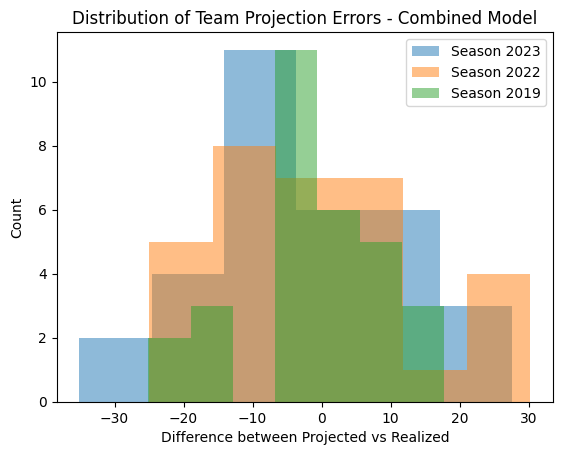

In [76]:
import matplotlib.pyplot as plt

legends = []

for season, df in reversed(pts_df_dict.items()):
    df['Diff'] = df['Diff'] * -1
    plt.hist(df['Diff'], bins='auto', alpha=0.5, label=f'Season {season}')
    legends.append(f'Season {season}')

# Show legends
plt.legend(legends)

# Customize plot labels
plt.title('Distribution of Team Projection Errors - Combined Model')
plt.xlabel('Difference between Projected vs Realized')
plt.ylabel('Count')

# Show the combined histogram
plt.show()

##### Testing Parameters

In [2]:
np.random.seed(0)

season_weight_ls = [0.65, 0.75]
#average_weight = 0.3
K_list = [6,8,10]
num_simulations = 1000
year = 2022

for K in K_list:
    for s_w in season_weight_ls:
        avg_w = 1 - s_w
        mean_pts, MeanAE, RSS = forecast_tester(K, s_w, avg_w, num_simulations, year, real_scores)
        all_models = add_testing_row(all_models, K, s_w, avg_w, num_simulations, MeanAE, RSS)
    print(f'{K} is done')

all_models.to_csv('C:/Users/Gabriel/Documents/MIE368/Data/new_elo_sim_test_results_2022.csv', index=False)

NameError: name 'np' is not defined

In [19]:
print(all_models)

       K  Season Weight  Avg Weight   NSims        MAE          RSS
0    6.0            0.7         0.3  1000.0   8.867400  4030.551840
1    6.0            0.8         0.2  1000.0   9.074700  4127.649169
2    6.0            0.9         0.1  1000.0   9.277367  4269.552435
3   10.0            0.7         0.3  1000.0   9.511400  4580.774778
4   10.0            0.8         0.2  1000.0   9.585400  4821.267356
5   10.0            0.9         0.1  1000.0  10.258967  5281.897507
6   12.0            0.7         0.3  1000.0   9.889000  5031.585206
7   12.0            0.8         0.2  1000.0  10.060000  5195.831618
8   12.0            0.9         0.1  1000.0  10.784833  5785.813667
9   15.0            0.7         0.3  1000.0  10.294033  5411.811813
10  15.0            0.8         0.2  1000.0  10.768300  5834.520757
11  15.0            0.9         0.1  1000.0  11.341167  6312.874641
